In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
pantry=pd.read_csv('/content/gdrive/MyDrive/dataPhilly_ElderNet/pantry.csv',parse_dates=['assistance_date'])
clientinfo=pd.read_csv('/content/gdrive/MyDrive/dataPhilly_ElderNet/Client_data2.csv')

**Pantry Info**

    1. Look at nulls/NAs
    2. Transpose donations to one column per type (e.g. pantry_pounds,holiday_pounds,easter_pounds,pantry_dollars,holiday_dollars,easter_dollars)
    3. Transpose assistance_dates to first/last/count/duration, i.e. convert assistance_date to first_assistance, last_assistance, assistance_count, assistance_duration
       a) drop original assistance
       b) drop duplicate rows based on anon_ID
    4.  Evaluate by assistance_date
    5.  Evaluate by anon_ID
    6.  Merge with client_info and look at poverty, minority, age group breakdowns    



In [4]:
# Convert DateTime to Date
pantry['assistance_date']=pd.to_datetime(pantry['assistance_date']).dt.date

In [5]:
pantry.head(3)


,anon_ID,assistance_date,assistance_category,amount,unit
0,102,2019-01-03,Food Pantry: Food Pantry Poundage,25,Pounds
1,178,2019-01-03,Food Pantry: Food Pantry Poundage,25,Pounds
2,588,2019-01-03,Food Pantry: Food Pantry Poundage,25,Pounds


In [6]:
pantry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6273 entries, 0 to 6272
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   anon_ID              6273 non-null   int64 
 1   assistance_date      6273 non-null   object
 2   assistance_category  6273 non-null   object
 3   amount               6273 non-null   int64 
 4   unit                 6273 non-null   object
dtypes: int64(2), object(3)
memory usage: 245.2+ KB


In [7]:
# Check for missing values
pantry.isnull().sum()

anon_ID                0
assistance_date        0
assistance_category    0
amount                 0
unit                   0
dtype: int64

In [8]:
# identify categories
pantry['assistance_category'].unique()

array(['Food Pantry: Food Pantry Poundage',
       'Food Pantry: Easter Outreach', 'Food Pantry: Holiday Baskets'],
      dtype=object)

In [9]:
pantry['unit'].unique()

array(['Pounds', 'Boxes/Bags', 'Dollars'], dtype=object)

## Look at food pantry over time
<p> Should I group by time, e.g. by "Month"?

In [10]:
food_poundage=pantry.groupby(['assistance_category','assistance_date'])
food_poundage.size().unstack()

assistance_date,2019-01-03,2019-01-07,2019-01-08,2019-01-10,2019-01-15,2019-01-17,2019-01-18,2019-01-21,2019-01-22,2019-01-23,...,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-24,2021-08-26,2021-08-31,2021-09-02,2021-09-07,2021-09-09
assistance_category,,,,,,,,,,,,,,,,,,,,,
Food Pantry: Easter Outreach,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Food Pantry: Food Pantry Poundage,21.0,2.0,22.0,19.0,8.0,20.0,1.0,1.0,23.0,1.0,...,3.0,24.0,1.0,6.0,14.0,28.0,12.0,20.0,19.0,1.0
Food Pantry: Holiday Baskets,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Look at usage of pantry based on number of accesses
<p> count number of assistance dates per date across all anon_IDs

In [11]:
# Create sub DF of assistance_date and counts, sorted by date
assistsByDate_df=pantry[['assistance_date','anon_ID']].sort_values('assistance_date',ascending=True)
assistsByDate_df.dropna(inplace=True)

# Create 2 column DF (date and count)
assistsByDate=assistsByDate_df.groupby('assistance_date',as_index=False).count()
#assistsByDate.dropna(inplace=True)
assistsByDate.rename(columns={'anon_ID':'countByDate'},inplace=True)

# Calculate simple moving average
assistsByDate['SMA30'] = assistsByDate['countByDate'].rolling(30).mean()

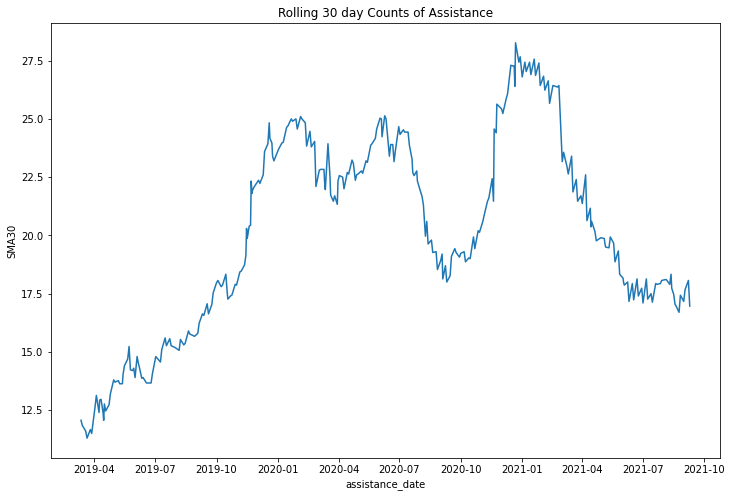

In [14]:
# Graph simple moving average over time
plt.figure(figsize=(12,8))
plt.title('Rolling 30 day Counts of Assistance')
sns.lineplot(x='assistance_date',y='SMA30',data=assistsByDate)

We want to calculate pounds and dollars over time.
<p> First need to Split the amount column into one column per assistance_category

In [15]:
# Split poundate out into one column per assistance_category/unit
pantryPounds_L=[]
pantryDollars_L=[]
easterPounds_L=[]
easterBags_L=[]
holidayPounds_L=[]
holidayDollars_L=[]
# Loop through all rows in dataframe.  Depending on combination of category and unit, store amount in new column
# eg Food Pantry Poundage AND Pounds --> pantry_pounds
#    Food Pantry Poundage AND dollars -> pantry_dollars
for ind in pantry.index:
	# category=Food Pantry: Food Pantry Poundage
	if (pantry['assistance_category'][ind]=='Food Pantry: Food Pantry Poundage') and (pantry['unit'][ind]=='Pounds'):
		pantryPounds_L.append(pantry['amount'][ind])
		pantryDollars_L.append('0')
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')
	elif (pantry['assistance_category'][ind]=='Food Pantry: Food Pantry Poundage') and (pantry['unit'][ind]=='Dollars'):
		pantryPounds_L.append('0')
		pantryDollars_L.append(pantry['amount'][ind])
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')
	elif (pantry['assistance_category'][ind]=='Food Pantry: Easter Outreach') and (pantry['unit'][ind]=='Pounds'):
		pantryPounds_L.append('0')
		pantryDollars_L.append(0)
		easterPounds_L.append(pantry['amount'][ind])
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')
	elif (pantry['assistance_category'][ind]=='Food Pantry: Easter Outreach') and (pantry['unit'][ind]=='Boxes/Bags'):
		pantryPounds_L.append('0')
		pantryDollars_L.append(0)
		easterPounds_L.append('0')
		easterBags_L.append(pantry['amount'][ind])
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')
	elif (pantry['assistance_category'][ind]=='Food Pantry: Holiday Baskets') and (pantry['unit'][ind]=='Pounds'):
		pantryPounds_L.append('0')
		pantryDollars_L.append(0)
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append(pantry['amount'][ind])
		holidayDollars_L.append('0')
	elif(pantry['assistance_category'][ind]=='Food Pantry: Holiday Baskets') and (pantry['unit'][ind]=='Dollars'):
		pantryPounds_L.append('0')
		pantryDollars_L.append('0')
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append(pantry['amount'][ind])
	else:
		pantryPounds_L.append('0')
		pantryDollars_L.append('0')
		easterPounds_L.append('0')
		easterBags_L.append('0')
		holidayPounds_L.append('0')
		holidayDollars_L.append('0')

# Append new category/unit columns
pantry['pantry_pounds']=pd.DataFrame(pantryPounds_L).astype(int)
pantry['pantry_dollars']=pd.DataFrame(pantryDollars_L).astype(int)
pantry['easter_pounds']=pd.DataFrame(easterPounds_L).astype(int)
pantry['easter_bags']=pd.DataFrame(easterBags_L).astype(int)
pantry['holiday_pounds']=pd.DataFrame(holidayPounds_L).astype(int)
pantry['holiday_dollars']=pd.DataFrame(holidayDollars_L).astype(int)

In [16]:
# Create similar graph of total poundage over time
# Create sub DF of assistance_date and pantry_pounds, sorted by date
pantryPounds_df=pantry[['assistance_date','pantry_pounds']].sort_values('assistance_date',ascending=True)
pantryPounds_df.dropna(inplace=True)

# create 2 column DF of date and count
pantryPounds=pantryPounds_df.groupby('assistance_date',as_index=False)['pantry_pounds'].sum()

# Calculate simple moving average
pantryPounds['poundsSMA30'] = pantryPounds['pantry_pounds'].rolling(30).mean()

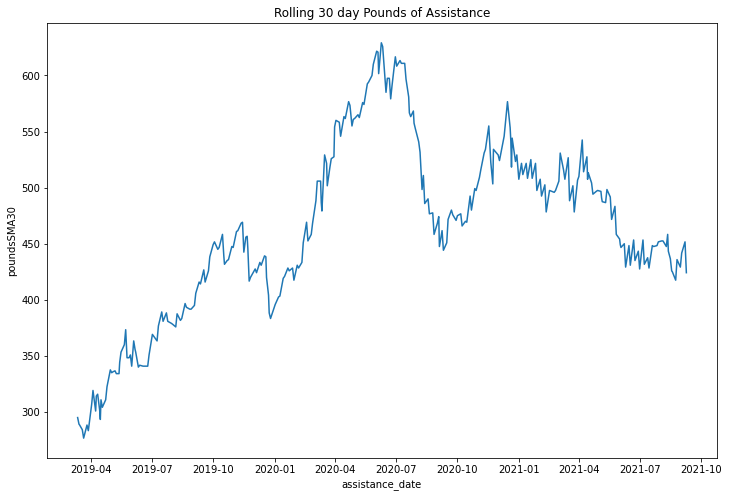

In [17]:
plt.figure(figsize=(12,8))
plt.title('Rolling 30 day Pounds of Assistance')
sns.lineplot(x='assistance_date',y='poundsSMA30',data=pantryPounds)

In [18]:
# Create similar graph of pantry dollars over time
# Create sub DF of assistance_date and pantry_dollars, sorted by date
pantryDollars_df=pantry[['assistance_date','pantry_dollars']].sort_values('assistance_date',ascending=True)
pantryDollars_df.dropna(inplace=True)

# create 2 column DF of date and count
pantryDollars=pantryDollars_df.groupby('assistance_date',as_index=False)['pantry_dollars'].sum()

# Calculate simple moving average
pantryDollars['dollarsSMA30'] = pantryDollars['pantry_dollars'].rolling(30).mean()

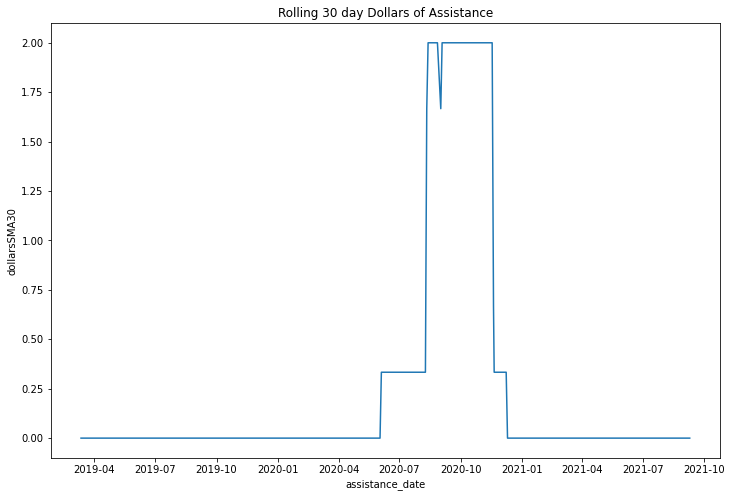

In [19]:
plt.figure(figsize=(12,8))
plt.title('Rolling 30 day Dollars of Assistance')
sns.lineplot(x='assistance_date',y='dollarsSMA30',data=pantryDollars)

# Merge with Client Data and show breakdown by
*   poverty
*   minority
*   age_group

In [20]:
# sort by anon_ID before merge
clientinfo.sort_values('anon_ID',inplace=True)
pantry.sort_values('anon_ID',inplace=True)

In [21]:
# Merge Client info and Pantry data
combined_df=pd.merge(clientinfo, pantry, on=['anon_ID'],how='outer') # use all keys

In [22]:
combined_df.head(2)

,anon_ID,county,poverty,minority,age_group,assistance_date,assistance_category,amount,unit,pantry_pounds,pantry_dollars,easter_pounds,easter_bags,holiday_pounds,holiday_dollars
0,1,Montgomery,No,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Montgomery,No,No,D,2020-04-14,Food Pantry: Food Pantry Poundage,25.0,Pounds,25.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# sort by date before group_by
combined_df=combined_df.sort_values('assistance_date',ascending=True)

In [24]:
# Create subset DF (date and count and poverty
combined_pov=combined_df[['assistance_date', 'poverty']]

In [25]:
# Break into two groups (Poverty=Y/N), then plot rolling (30day) sums?
pov_y_df=combined_pov[combined_pov['poverty']=='Yes']
pov_n_df=combined_pov[combined_pov['poverty']=='No']

# Calculate counts per date
pov_y=pov_y_df.groupby('assistance_date',as_index=False).count()
pov_n=pov_n_df.groupby('assistance_date',as_index=False).count()
pov_y.rename(columns={'poverty':'countPovY'},inplace=True)
pov_n.rename(columns={'poverty':'countPovN'},inplace=True)

# Calculate rolline 30 day averages
pov_y['povY30']=pov_y['countPovY'].rolling(30).mean()
pov_n['povN30']=pov_n['countPovN'].rolling(30).mean()

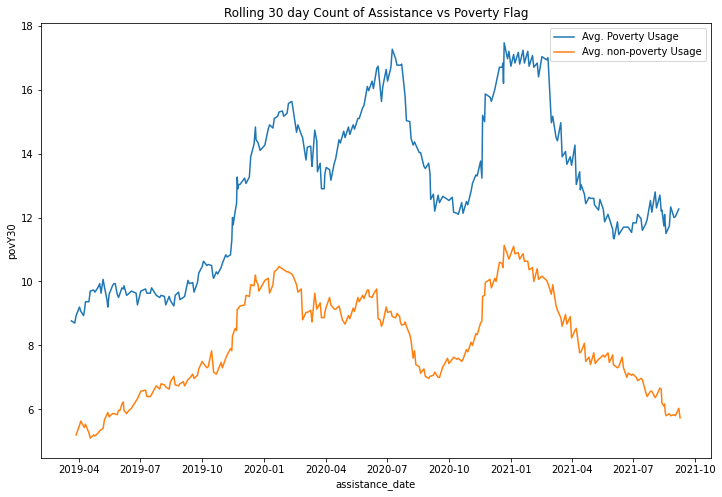

In [26]:
# Plot poverty vs non-poverty with 30 day rolling average
plt.figure(figsize=(12,8))
plt.title('Rolling 30 day Counts of Assistance vs Poverty')
plt.title('Rolling 30 day Count of Assistance vs Poverty Flag')
sns.lineplot(x='assistance_date',y='povY30',data=pov_y, label="Avg. Poverty Usage")
sns.lineplot(x='assistance_date',y='povN30',data=pov_n, label="Avg. non-poverty Usage")

==> Conclusion:  Those under poverty line had much higher average usage

In [27]:
# Create subset DF (date and count and minority
combined_min=combined_df[['assistance_date', 'minority']]

In [29]:
# Break into two groups (Minority=Y/N), then plot rolling (30day) averages?
min_y_df=combined_min[combined_min['minority']=='Yes']
min_n_df=combined_min[combined_min['minority']=='No']

# Calculate counts per date
min_y=min_y_df.groupby('assistance_date',as_index=False).count()
min_n=min_n_df.groupby('assistance_date',as_index=False).count()
min_y.rename(columns={'minority':'countMinY'},inplace=True)
min_n.rename(columns={'minority':'countMinN'},inplace=True)

# Calculate rolline 30 day averages
min_y['minY30']=min_y['countMinY'].rolling(30).mean()
min_n['minN30']=min_n['countMinN'].rolling(30).mean()

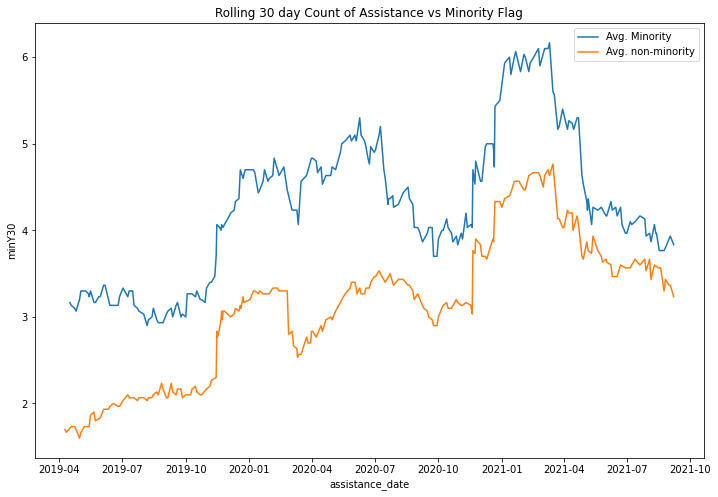

In [30]:
plt.figure(figsize=(12,8))
plt.title('Rolling 30 day Counts of Assistance vs Minority')
plt.title('Rolling 30 day Count of Assistance vs Minority Flag')
sns.lineplot(x='assistance_date',y='minY30',data=min_y, label="Avg. Minority")
sns.lineplot(x='assistance_date',y='minN30',data=min_n, label="Avg. non-minority")

Conclusion:  Minorities had consistently higher usage.  All users saw increase during pandemic

In [31]:
# Create subset DF (date and count and age_group
combined_age=combined_df[['assistance_date', 'age_group']]

In [32]:
combined_age.age_group.unique()

array(['T', 'G', nan, 'P', 'D'], dtype=object)

In [33]:
age_G_df=combined_age[combined_age['age_group']=='G']
age_T_df=combined_age[combined_age['age_group']=='T']
age_P_df=combined_age[combined_age['age_group']=='P']
age_D_df=combined_age[combined_age['age_group']=='D']

# Calculate counts per date
age_G=age_G_df.groupby('assistance_date',as_index=False).count()
age_T=age_T_df.groupby('assistance_date',as_index=False).count()
age_P=age_P_df.groupby('assistance_date',as_index=False).count()
age_D=age_D_df.groupby('assistance_date',as_index=False).count()

age_G.rename(columns={'age_group':'countAgeG'},inplace=True)
age_T.rename(columns={'age_group':'countAgeT'},inplace=True)
age_P.rename(columns={'age_group':'countAgeP'},inplace=True)
age_D.rename(columns={'age_group':'countAgeD'},inplace=True)

# Calculate rolline 30 day averages
age_G['ageG30']=age_G['countAgeG'].rolling(30).mean()
age_T['ageT30']=age_T['countAgeT'].rolling(30).mean()
age_P['ageP30']=age_P['countAgeP'].rolling(30).mean()
age_D['ageD30']=age_D['countAgeD'].rolling(30).mean()

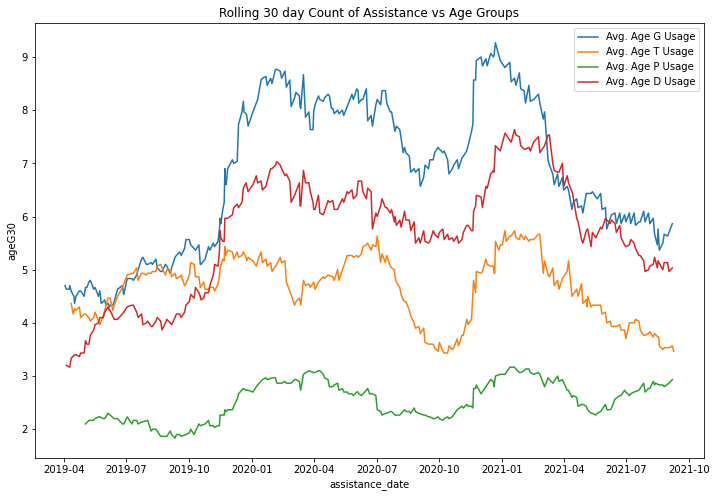

In [34]:
#  Plot Rolling 30 vs Age Groups
plt.figure(figsize=(12,8))
plt.title('Rolling 30 day Count of Assistance vs Age Groups')
sns.lineplot(x='assistance_date',y='ageG30',data=age_G, label="Avg. Age G Usage")
sns.lineplot(x='assistance_date',y='ageT30',data=age_T, label="Avg. Age T Usage")
sns.lineplot(x='assistance_date',y='ageP30',data=age_P, label="Avg. Age P Usage")
sns.lineplot(x='assistance_date',y='ageD30',data=age_D, label="Avg. Age D Usage")


Conclusion:  Age group "G" required much more assistance during peak of Pandemic.  Age group "P" was fairly constant usage.

Conclusion:  Minority use greatly increased during pandemic

### Analyze by individual usage/sums and counts instead of versus date

Identify First and Last Assistance Dates of Pantry Assistance.
<p>Calculate Duration (LastDate-FirstDate)

In [35]:
# Append a column 'first_assist' based on minimum date per anon_ID
first_assist=pantry.groupby(['anon_ID'])['assistance_date'].min()
cm_min_df=pd.DataFrame(first_assist)
cm_min_df.rename(columns={'assistance_date':'pantry_first_assist'},inplace=True)
pantry=pd.merge(pantry,cm_min_df, on=['anon_ID'])

# Append a column 'last_assist' based on maximum date per anon_ID
last_assist=pantry.groupby(['anon_ID'])['assistance_date'].max()
cm_max_df=pd.DataFrame(last_assist)
cm_max_df.rename(columns={'assistance_date':'pantry_last_assist'},inplace=True)
pantry=pd.merge(pantry,cm_max_df, on=['anon_ID'])

# durationOfAssist = lastAssist - firstAssist
pantry['pantry_duration'] =pantry['pantry_last_assist']-pantry['pantry_first_assist']

For each anon_ID, Calculate sum of assisst by assistance_category
Iterate over each row
<p>If assistance_category "Food Pantry: Food Pantry Poundage" && Pounds, then populate column pantry_pounds
repeat for each category type and unit combination
<p>Goal:  convert to columns with uniform units
<p><p>  Then will sum each new column per AnonID and give count per AnonID 


In [36]:
# Calculate sum by each new column (pantry_pounds, pantry_dollars, etc.)
# pantry pounds
#  Create a list of sums by ID
#  Create temporary dataframe with that list
#  Rename the new column to reflect it is a sum
#  Merge that dataframe with the main one
mySums=pantry.groupby(['anon_ID'])['pantry_pounds'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'pantry_pounds':'sumPantryPounds'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# pantry dollars
pantry['pantry_dollars'].astype(str) # can only build list of strings?
mySums=pantry.groupby(['anon_ID'])['pantry_dollars'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'pantry_dollars':'sumPantryDollars'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# easter pounds
mySums=pantry.groupby(['anon_ID'])['easter_pounds'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'easter_pounds':'sumEasterPounds'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# easter bags
mySums=pantry.groupby(['anon_ID'])['easter_bags'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'easter_bags':'sumEasterBags'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# holiday pounds
mySums=pantry.groupby(['anon_ID'])['holiday_pounds'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'holiday_pounds':'sumHolidayPounds'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])

# holiday dollars
mySums=pantry.groupby(['anon_ID'])['holiday_dollars'].sum()
mySums_df=pd.DataFrame(mySums)
mySums_df.rename(columns={'holiday_dollars':'sumHolidayDollars'},inplace=True)
pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])


In [37]:
# Calculate counts by anon_ID
myCounts=pantry.groupby(['anon_ID'])['assistance_date'].count()
myCounts_df=pd.DataFrame(myCounts)
myCounts_df.rename(columns={'assistance_date':'countPantryAssists'},inplace=True)
pantry=pd.merge(pantry,myCounts_df, on=['anon_ID'])

In [38]:
# Drop duplicate rows to get to one sum or count per anon_ID
pantry2=pantry.drop_duplicates(subset='anon_ID',inplace=True)

In [39]:
# Drop columns: assistance_date, assistance_category, amount, unit
pantry2=pantry.drop('assistance_date',axis=1)
pantry2=pantry.drop('assistance_category',axis=1)
pantry2=pantry.drop('amount',axis=1)
pantry2=pantry.drop('unit',axis=1)

# Now that summed up, no longer need Pantry_Pounds & Dollars/EasterPounds&Dollars/HolidayPounds&Dollars
pantry2=pantry.drop('pantry_pounds',axis=1)
pantry2=pantry.drop('pantry_dollars',axis=1)
pantry2=pantry.drop('easter_pounds',axis=1)
pantry2=pantry.drop('easter_bags',axis=1)
pantry2=pantry.drop('holiday_pounds',axis=1)
pantry2=pantry.drop('holiday_dollars',axis=1)



In [40]:
pantry2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
anon_ID,414.0,319.297101,187.389783,2.0,152.25,315.5,483.5,639.0
amount,414.0,25.68599,2.726952,4.0,25.0,25.0,25.0,50.0
pantry_pounds,414.0,21.256039,8.931656,0.0,25.0,25.0,25.0,25.0
pantry_dollars,414.0,0.024155,0.491473,0.0,0.0,0.0,0.0,10.0
easter_pounds,414.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
easter_bags,414.0,0.009662,0.196589,0.0,0.0,0.0,0.0,4.0
holiday_pounds,414.0,3.913043,10.115659,0.0,0.0,0.0,0.0,30.0
pantry_duration,414,373 days 13:02:36.521739132,342 days 23:18:25.864954008,0 days 00:00:00,29 days 06:00:00,332 days 12:00:00,657 days 18:00:00,978 days 00:00:00
sumPantryPounds,414.0,350.966184,442.795061,0.0,25.0,150.0,543.75,2350.0
sumPantryDollars,414.0,0.169082,1.466465,0.0,0.0,0.0,0.0,20.0


In [41]:
combined2_df=pd.merge(clientinfo, pantry2, on=['anon_ID'],how='outer') # use all keys

In [42]:
assistsByDate=combined2_df.groupby('assistance_date',as_index=False).count()
#assistsByDate.dropna(inplace=True)
assistsByDate.rename(columns={'anon_ID':'countByDate'},inplace=True)

In [43]:
combinedCount_L=combined2_df.groupby(['countPantryAssists'],as_index=False)['anon_ID'].count()
combinedCount_df=pd.DataFrame(combinedCount_L).sort_values('anon_ID',ascending=False)
##mySums_df.rename(columns={'pantry_pounds':'sumPantryPounds'},inplace=True)
##pantry=pd.merge(pantry,mySums_df, on=['anon_ID'])
combinedCount_df.rename(columns={'anon_ID':'NumIDsPerCount'},inplace=True)

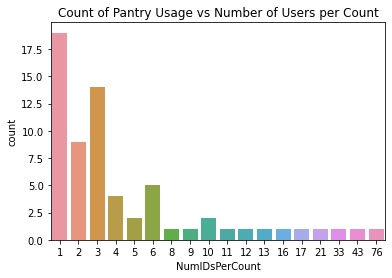

In [44]:
# Graph as grouped by xxx
plt.title('Count of Pantry Usage vs Number of Users per Count')
sns.countplot(x='NumIDsPerCount',data=combinedCount_df)